GeoJSON файл сгенерирован: output.geojson


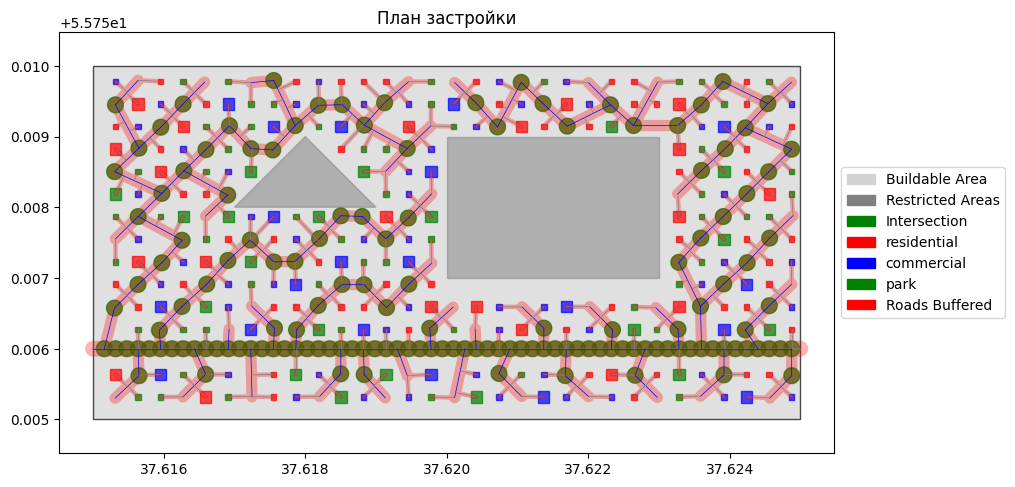

Изображение плана застройки сохранено в output.png


In [3]:
# Импорт библиотек
import geopandas as gpd
import shapely.geometry
import shapely.ops
import shapely.validation
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import json
import numpy as np
from pyproj import CRS, Transformer
import networkx as nx
from sklearn.neighbors import NearestNeighbors
from itertools import combinations

# --- Глобальные константы ---
# Параметры для разных типов объектов
OBJECT_TYPES = {
    "residential": {
        "density": 0.3,
        "min_distance": 15,
        "building_size": 10,
        "color": "red"
    },
    "commercial": {
        "density": 0.1,
        "min_distance": 20,
        "building_size": 15,
        "color": "blue"
    },
     "park": {
        "density": 0.2,
        "min_distance": 5,
        "building_size": 5,
        "color": "green"
    }
}

# CRS (системы координат)
CRS_WGS84 = CRS("EPSG:4326")
CRS_UTM = CRS("EPSG:32637")  # UTM zone 37N (for Moscow)

# Максимальное расстояние до дороги
MAX_ROAD_DISTANCE = 100  # в метрах

# Типы дорог (для иерархии)
ROAD_TYPES = {
    "main": {
        "width": 7
    },
    "secondary": {
        "width": 5,
        "k_neighbors": 3,
        "random_weight_factor": 0.5,
        "intersection_radius": 7
    },
    "local": {
        "width": 2
    }
}
# --- Функции для работы с координатами ---
def to_utm(lon, lat):
    """Переводит координаты из WGS 84 (долгота, широта) в UTM."""
    return transformer_to_utm.transform(lon, lat)

def from_utm(x, y):
    """Переводит координаты из UTM в WGS 84 (долгота, широта)."""
    return transformer_from_utm.transform(x, y)

def calculate_degree_distance(meters, center_lon, center_lat):
    """Вычисляет эквивалент расстояния в метрах в градусах для заданной точки."""
    center_x, center_y = to_utm(center_lon, center_lat)
    x_dist = center_x + meters
    lon_dist, _ = from_utm(x_dist, center_y)
    return abs(lon_dist - center_lon)

# --- Функции для обработки геометрий ---

def load_and_validate_data(filepath):
    """Загружает данные из GeoJSON файла и проверяет геометрии."""
    try:
        data = gpd.read_file(filepath)
    except FileNotFoundError:
        print(f"Ошибка: Файл {filepath} не найден.")
        exit()

    for index, row in data.iterrows():
        if not row['geometry'].is_valid:
            print(f"Warning: Некорректная геометрия в строке {index}")
            data.loc[index, 'geometry'] = shapely.validation.make_valid(row['geometry'])
    return data

def get_buildable_area(data):
    """Извлекает и объединяет зоны застройки."""
    buildable_area = data[data['id'] == 'buildable_area']
    if buildable_area.empty:
        print("Ошибка: Зона застройки не найдена.")
        exit()
    buildable_area = shapely.ops.unary_union(buildable_area.geometry)

    if not isinstance(buildable_area, shapely.geometry.Polygon):
      if isinstance(buildable_area, shapely.geometry.MultiPolygon):
          # Выбираем самый большой полигон, если их несколько
          buildable_area = max(buildable_area.geoms, key=lambda a: a.area)
      else:
          print("Ошибка: Зона застройки имеет некорректный тип")
          exit()
    return buildable_area


def get_restricted_areas(data):
    """Извлекает и объединяет зоны с ограничениями."""
    restricted_areas = data[data['restriction'] == 'no_build']
    if restricted_areas.empty:
      return None
    return shapely.ops.unary_union(restricted_areas.geometry)

def get_main_road(data):
    """Извлекает главную дорогу."""
    main_road = data[data['id'] == 'road']
    if main_road.empty:
        print("Ошибка: Главная дорога не найдена.")
        exit()
    main_road = shapely.ops.unary_union(main_road.geometry)
    if not isinstance(main_road, shapely.geometry.LineString) and not isinstance(main_road, shapely.geometry.MultiLineString):
        print("Ошибка: главная дорога имеет неверный тип")
        exit()
    return main_road

def buffer_road(road, width_deg):
    """Создает буфер для дороги заданной ширины."""
    return road.buffer(width_deg)

def create_intersection(point, radius_deg):
    """Создает кольцевой перекресток (буфер вокруг точки)."""
    return point.buffer(radius_deg)

def create_grid(buildable_area, grid_step):
    """Создает сетку точек внутри зоны застройки."""
    min_x, min_y, max_x, max_y = buildable_area.bounds
    x_coords = np.arange(min_x, max_x, grid_step)
    y_coords = np.arange(min_y, max_y, grid_step)
    grid_points = [shapely.geometry.Point(x, y) for x in x_coords for y in y_coords]
    return gpd.GeoSeries(grid_points)

def filter_grid(grid_points, buildable_area, restricted_areas, max_building_size_deg):
    """Фильтрует точки сетки, оставляя только те, которые находятся внутри зоны
       застройки и не пересекаются с запретными зонами."""
    filtered_points = []
    for point in grid_points:
        building = shapely.geometry.box(point.x - max_building_size_deg / 2,
                                         point.y - max_building_size_deg / 2,
                                         point.x + max_building_size_deg / 2,
                                         point.y + max_building_size_deg / 2)
        # Исправлено: убрали .buffer() из restricted_areas
        if building.within(buildable_area) and (restricted_areas is None or not building.intersects(restricted_areas)):
            filtered_points.append(point)
    return gpd.GeoSeries(filtered_points)

def generate_secondary_roads(grid_points, main_road, road_params):
    """Генерирует второстепенные дороги, используя алгоритм MST на k-NN графе."""

    # 1. Прореживание точек сетки
    grid_points_thinned = grid_points[::3]

    # 2. Создаем граф
    graph = nx.Graph()

    # 3. Добавляем вершины (точки сетки) с "шумом"
    points_list = list(grid_points_thinned)
    noisy_points = []
    noise_factor = road_params["width_deg"] / 4
    for point in points_list:
        new_x = point.x + np.random.uniform(-noise_factor, noise_factor)
        new_y = point.y + np.random.uniform(-noise_factor, noise_factor)
        noisy_points.append(shapely.geometry.Point(new_x, new_y))

    for point in noisy_points:
        graph.add_node(point, pos=(point.x, point.y))

    # 4. Добавляем вершины (точки на главной дороге)
    road_points = []
    for i in np.arange(0, main_road.length, road_params["width_deg"] * 2):
        point = main_road.interpolate(i)
        graph.add_node(point, pos=(point.x, point.y))
        road_points.append(point)

    # 5. Строим k-NN граф
    coords = np.array([[p.x, p.y] for p in graph.nodes])
    knn = NearestNeighbors(n_neighbors=road_params["k_neighbors"] + 1)
    knn.fit(coords)
    distances, indices = knn.kneighbors(coords)

    # 6. Добавляем ребра (с учетом k-NN и случайных весов)
    for i, point in enumerate(graph.nodes):
        for j in range(1, road_params["k_neighbors"] + 1):
            neighbor_idx = indices[i, j]
            neighbor = list(graph.nodes)[neighbor_idx]
            distance = point.distance(neighbor)
            random_weight = 1 + (np.random.rand() - 0.5) * road_params["random_weight_factor"]
            graph.add_edge(point, neighbor, weight=distance * random_weight)

    # 7. Строим MST
    mst = nx.minimum_spanning_tree(graph)

    # 8. Дороги - это ребра MST
    secondary_roads = [shapely.geometry.LineString([u, v]) for u, v in mst.edges]
    return secondary_roads


def connect_dead_ends(secondary_roads, graph, buildable_area, restricted_areas):
    """Соединяет тупиковые вершины второстепенных дорог с ближайшими дорогами."""
    mst = nx.Graph()
    for road in secondary_roads:
        mst.add_edge(shapely.geometry.Point(road.coords[0]), shapely.geometry.Point(road.coords[-1]))

    dead_ends = [node for node, degree in mst.degree() if degree == 1]

    for dead_end in dead_ends:
        edges_to_exclude = list(mst.edges(dead_end))
        other_roads = [shapely.geometry.LineString([u, v]) for u, v in graph.edges if (u, v) not in edges_to_exclude and (v, u) not in edges_to_exclude]

        if not other_roads:
            continue

        other_roads_union = shapely.ops.unary_union(other_roads)
        nearest_point = shapely.ops.nearest_points(dead_end, other_roads_union)[1]
        connecting_road = shapely.geometry.LineString([dead_end, nearest_point])

        if not connecting_road.intersects(buildable_area) and (restricted_areas is None or not connecting_road.intersects(restricted_areas)):
            secondary_roads.append(connecting_road)
    return secondary_roads

def generate_intersections(roads, intersection_radius_deg):
    """Генерирует перекрестки в точках пересечения дорог, объединяя близкие."""
    intersection_points = []
    for road1, road2 in combinations(roads, 2):
        if road1.intersects(road2):
            intersection = road1.intersection(road2)
            if isinstance(intersection, shapely.geometry.MultiPoint):
                intersection_points.extend(list(intersection.geoms))
            elif isinstance(intersection, shapely.geometry.Point):
                intersection_points.append(intersection)

    # Объединяем близкие точки
    if not intersection_points:
        return []
    points_union = shapely.ops.unary_union(intersection_points)
    buffered_points = points_union.buffer(intersection_radius_deg / 2)  # Половина радиуса
    if isinstance(buffered_points, shapely.geometry.polygon.Polygon):
        buffered_points = shapely.geometry.MultiPolygon([buffered_points])

    # Создаем перекрестки для центроидов объединенных точек
    intersections = [polygon.centroid.buffer(intersection_radius_deg) for polygon in buffered_points.geoms]
    return intersections

def generate_local_roads(placed_objects, all_secondary_and_main_roads, object_types_params):
    """Генерирует локальные дороги от объектов к ближайшим второстепенным/главной дорогам."""
    local_roads = []
    for obj in placed_objects:
        nearest_point = shapely.ops.nearest_points(obj.centroid, all_secondary_and_main_roads)[1]
        local_road = shapely.geometry.LineString([obj.centroid, nearest_point])

        # Исправлено: проверяем пересечения ТОЛЬКО со зданиями, а не с дорогами
        intersects = False
        for other_obj in placed_objects:
            if other_obj != obj and local_road.intersects(other_obj):
                intersects = True
                break
        if not intersects:
            local_roads.append(local_road)
    return local_roads

def place_objects(grid_points, buildable_area, restricted_areas, all_roads, object_types_params):
    """Размещает объекты на сетке с учетом ограничений."""
    placed_objects = []
    available_area_total = buildable_area.area

    for obj_type, params in object_types_params.items():
        # Дороги пропускаем
        if obj_type == "road":
            continue

        available_area = available_area_total * OBJECT_TYPES[obj_type]["density"]

        # Добавили отступ от краев зоны застройки
        buildable_area_inset = buildable_area.buffer(-params["min_distance_deg"])
        if buildable_area_inset.is_empty or not isinstance(buildable_area_inset, shapely.geometry.Polygon):
          # Если после буферизации полигон исчез (стал слишком маленьким) - пропускаем этот тип
          continue

        for point in grid_points:
            building = shapely.geometry.box(point.x - params["building_size_deg"] / 2,
                                             point.y - params["building_size_deg"] / 2,
                                             point.x + params["building_size_deg"] / 2,
                                             point.y + params["building_size_deg"] / 2)
            # Добавили проверку на отступ от краев и углов
            if not building.within(buildable_area_inset):
                continue

            intersects = False
            for other_obj in placed_objects:
                if building.intersects(other_obj.buffer(params["min_distance_deg"])): #Проверка с буффером
                    intersects = True
                    break
            if not intersects:
                if all_roads is not None and building.intersects(all_roads):
                    intersects = True

            if (not intersects and building.within(buildable_area) and
                    (restricted_areas is None or not building.intersects(restricted_areas))):
                if building.area <= available_area:
                    placed_objects.append(building)
                    available_area -= building.area
                else:
                    break  # Достигнут предел плотности
    return placed_objects

def generate_geojson(placed_objects, main_road_buffered, secondary_roads, local_roads, intersections, object_types_params):
    """Генерирует GeoJSON файл с размещенными объектами."""
    all_features = []
    obj_counter = 0

    # Здания и парки
    for obj, obj_type in zip(placed_objects, [list(OBJECT_TYPES.keys())[i%len(OBJECT_TYPES)] for i in range(len(placed_objects))]):
        feature = {
            "type": "Feature",
            "properties": {
                "type": obj_type,
                "id": obj_counter
            },
            "geometry": shapely.geometry.mapping(obj)
        }
        obj_counter += 1
        all_features.append(feature)

    # Главная дорога
    feature = {
        "type": "Feature",
        "properties": {
            "type": "road",
            "road_type": "main",
            "id": obj_counter
        },
        "geometry": shapely.geometry.mapping(main_road_buffered)
    }
    obj_counter += 1
    all_features.append(feature)

    # Второстепенные дороги
    for i, road in enumerate(secondary_roads):
        feature = {
            "type": "Feature",
            "properties": {
                "type": "road",
                "road_type": "secondary",
                "id": obj_counter + i
            },
            "geometry": shapely.geometry.mapping(road)
        }
        all_features.append(feature)
    obj_counter += len(secondary_roads)

    # Локальные дороги
    for i, road in enumerate(local_roads):
        feature = {
            "type": "Feature",
            "properties": {
                "type": "road",
                "road_type": "local",
                "id": obj_counter + i
            },
            "geometry": shapely.geometry.mapping(road)
        }
        all_features.append(feature)
    obj_counter += len(local_roads)

   # Перекрестки
    for i, intersection in enumerate(intersections):
        feature = {
            "type": "Feature",
             "properties": {
                "type": "road",
                "road_type": "intersection",
                "id": obj_counter + i
            },
            "geometry": shapely.geometry.mapping(intersection)
        }
        all_features.append(feature)

    # Создание FeatureCollection
    output_geojson = {
        "type": "FeatureCollection",
        "features": all_features
    }
    return output_geojson

def visualize_results(buildable_area, restricted_areas, placed_objects, main_road,
                      secondary_roads, local_roads, intersections, all_roads, object_types_params, filename="output.png"):
    """Визуализирует результаты и сохраняет изображение."""

    fig, ax = plt.subplots(figsize=(10, 10))

    # Отрисовка зоны застройки
    if isinstance(buildable_area, shapely.geometry.Polygon):
        polygon = mpatches.Polygon(list(buildable_area.exterior.coords), facecolor='lightgray', edgecolor='black', alpha=0.7)
        ax.add_patch(polygon)
    buildable_area_patch = mpatches.Patch(color='lightgray', label='Buildable Area')


    # Отрисовка зон с ограничениями
    if restricted_areas is not None:
      if isinstance(restricted_areas, shapely.geometry.MultiPolygon) or isinstance(restricted_areas, shapely.geometry.GeometryCollection):
        for geom in restricted_areas.geoms:
            if isinstance(geom, shapely.geometry.Polygon):
                polygon = mpatches.Polygon(list(geom.exterior.coords), color='gray', alpha=0.5)
                ax.add_patch(polygon)
            elif isinstance(geom, shapely.geometry.LineString):
                line = mlines.Line2D(*zip(*geom.coords), color='gray', alpha=0.5)
                ax.add_line(line)
      elif isinstance(restricted_areas, shapely.geometry.Polygon):
        polygon = mpatches.Polygon(list(restricted_areas.exterior.coords), color='gray', alpha=0.5)
        ax.add_patch(polygon)
      elif isinstance(restricted_areas, shapely.geometry.LineString):
        line = mlines.Line2D(*zip(*restricted_areas.coords), color='gray', alpha=0.5)
        ax.add_line(line)

    restricted_area_patch = mpatches.Patch(color='gray', label='Restricted Areas')

    # Отрисовка размещенных объектов
    legend_handles = [buildable_area_patch, restricted_area_patch]

    # Дороги (сначала небуферизованные)
    for road in secondary_roads:
        line = mlines.Line2D(*zip(*road.coords), color="blue", linewidth=0.5, label="Secondary Road")
        ax.add_line(line)

    for road in local_roads:
        line = mlines.Line2D(*zip(*road.coords), color="gray", linewidth=0.5, label="Local Road")
        ax.add_line(line)


    for intersection in intersections:
        polygon = mpatches.Polygon(list(intersection.exterior.coords), color="green", alpha=0.7)
        ax.add_patch(polygon)
        legend_handles.append(mpatches.Patch(color='green', label='Intersection'))

    # Объекты
    for obj, obj_type in zip(placed_objects, [list(OBJECT_TYPES.keys())[i%len(OBJECT_TYPES)] for i in range(len(placed_objects))]):
        color = OBJECT_TYPES[obj_type]["color"]
        if isinstance(obj, shapely.geometry.Polygon):
            polygon = mpatches.Polygon(list(obj.exterior.coords), color=color, alpha=0.7)
            ax.add_patch(polygon)
            legend_handles.append(mpatches.Patch(color=color, label=obj_type))

    # Дороги (одним объектом)
    if not all_roads.is_empty:
        gpd.GeoSeries([all_roads]).plot(ax=ax, color="red", alpha=0.3, label = "Roads Buffered")
        legend_handles.append(mpatches.Patch(color='red', label='Roads Buffered'))

    # Добавление легенды (без дубликатов)
    unique_handles = []
    unique_labels = []
    for handle, label in zip(legend_handles, [h.get_label() for h in legend_handles]):
        if label not in unique_labels:
            unique_labels.append(label)
            unique_handles.append(handle)

    plt.legend(handles=unique_handles, labels=unique_labels, loc='center left', bbox_to_anchor=(1, 0.5))

    # Установка заголовка
    plt.title("План застройки")

    # Установка пределов осей!
    minx, miny, maxx, maxy = buildable_area.bounds
    max_building_size_deg = max([params["building_size_deg"] for params in object_types_params.values()])
    ax.set_xlim(minx - max_building_size_deg*2, maxx + max_building_size_deg*2)
    ax.set_ylim(miny - max_building_size_deg*2, maxy + max_building_size_deg*2)

    # Сохраняем соотношение сторон!
    ax.set_aspect('equal')

    # Сохранение изображения
    plt.savefig(filename)

    # Показ изображения
    plt.show()
    print(f"Изображение плана застройки сохранено в {filename}")

# --- Основная часть программы ---

if __name__ == "__main__":
    # Путь к файлу с входными данными
    input_file = "./data/input.geojson"  #  Укажите свой путь

    # Создаем трансформеры для перевода координат
    transformer_to_utm = Transformer.from_crs(CRS_WGS84, CRS_UTM, always_xy=True)
    transformer_from_utm = Transformer.from_crs(CRS_UTM, CRS_WGS84, always_xy=True)

    # 1. Загрузка и предобработка данных
    data = load_and_validate_data(input_file)
    buildable_area = get_buildable_area(data)
    restricted_areas = get_restricted_areas(data)
    main_road = get_main_road(data)

    # 2. Параметры застройки (в градусах)
    center_lon, center_lat = buildable_area.centroid.x, buildable_area.centroid.y
    object_types_params = {}
    for obj_type, params in OBJECT_TYPES.items():
        object_types_params[obj_type] = params.copy()
        object_types_params[obj_type]["min_distance_deg"] = calculate_degree_distance(params["min_distance"], center_lon, center_lat)
        object_types_params[obj_type]["building_size_deg"] = calculate_degree_distance(params["building_size"], center_lon, center_lat)

    for road_type, road_params in ROAD_TYPES.items():
        ROAD_TYPES[road_type]["width_deg"] = calculate_degree_distance(road_params["width"], center_lon, center_lat)
        if "intersection_radius" in road_params:
            ROAD_TYPES[road_type]["intersection_radius_deg"] = calculate_degree_distance(road_params["intersection_radius"], center_lon, center_lat)

    max_road_distance_deg = calculate_degree_distance(MAX_ROAD_DISTANCE, center_lon, center_lat)

    # 3. Создание и фильтрация сетки
    max_building_size_deg = max([params["building_size_deg"] for params in object_types_params.values()])
    max_min_distance_deg = max([params["min_distance_deg"] for params in object_types_params.values()])
    grid_step = max(max_building_size_deg, max_min_distance_deg)

    grid_points = create_grid(buildable_area, grid_step)
    filtered_grid_points = filter_grid(grid_points, buildable_area, restricted_areas, max_building_size_deg)

    # 4. Размещение дорог
    # Второстепенные дороги
    secondary_roads = generate_secondary_roads(filtered_grid_points, main_road, ROAD_TYPES["secondary"])
    secondary_roads = connect_dead_ends(secondary_roads, nx.Graph([(road.coords[0], road.coords[-1]) for road in secondary_roads]), buildable_area, restricted_areas)
    intersections = generate_intersections(secondary_roads, ROAD_TYPES["secondary"]["intersection_radius_deg"])

    # 5. Размещение объектов
     # Перемешиваем точки для случайного размещения
    grid_points_shuffled = filtered_grid_points.sample(frac=1).reset_index(drop=True)

    # Сначала буферизуем главную дорогу
    main_road_buffered = buffer_road(main_road, ROAD_TYPES["main"]["width_deg"])

    # Объединяем все дороги (буферизованные) для проверок
    all_roads = [main_road_buffered]
    for road in secondary_roads:
        all_roads.append(buffer_road(road, ROAD_TYPES["secondary"]["width_deg"]))
    all_roads.extend(intersections)
    all_roads = shapely.ops.unary_union(all_roads)

    placed_objects = place_objects(grid_points_shuffled, buildable_area, restricted_areas, all_roads, object_types_params)

    # 6. Создание локальных дорог.
    all_secondary_and_main_roads = shapely.ops.unary_union([main_road] + secondary_roads) #НЕ буферизованные!
    local_roads = generate_local_roads(placed_objects, all_secondary_and_main_roads, object_types_params)

    # Добавляем локальные дороги в all_roads (буферизованные)
    for road in local_roads:
      all_roads = shapely.ops.unary_union([all_roads, buffer_road(road, ROAD_TYPES["local"]["width_deg"])])

    # 7. Генерация GeoJSON и визуализация
    output_geojson = generate_geojson(placed_objects, main_road_buffered, secondary_roads, local_roads, intersections, object_types_params)

    with open("output.geojson", "w") as f:
        json.dump(output_geojson, f, indent=2)
    print("GeoJSON файл сгенерирован: output.geojson")

    visualize_results(buildable_area, restricted_areas, placed_objects, main_road,
                      secondary_roads, local_roads, intersections, all_roads, object_types_params)
